
<span style="font-size:20px;">**Project: Spectral Modularity Partitioning of the Karate Club Graph**</span>



__Introduction__

This notebook implements the recursive spectral modularity partitioning algorithm, as described in the assignment, to identify community structures within Zachary's Karate Club graph. The project proceeds in several key stages:   

1. Setup: Importing necessary libraries.
2. Data Loading & Pre-computation: Loading the graph and computing global properties like the modularity matrix and a fixed layout.
3. Algorithm Implementation: Defining the helper functions and the main recursive bisection algorithm.   
4. Post-processing: Refining the resulting communities by reassigning "singleton" nodes.
5. Metric Analysis: Plotting the evolution of node centrality metrics to analyze network roles.   
6. Summary: Displaying a final summary of all findings.
7. Discussion: A final written analysis of the results.   

__Cell 1: Library Imports__  

This first cell sets up the Python environment. It imports all libraries required for the analysis:

- networkx for creating, manipulating, and analyzing the graph.   
- numpy for numerical operations and linear algebra (eigenvector computation).   
- pandas for organizing and storing the node metrics in a DataFrame.   
- scipy.sparse.linalg.eigsh as a fallback solver for eigenvalues.   
- matplotlib.pyplot and seaborn for all visualizations.
- %matplotlib inline is a Jupyter "magic" command that ensures all plots render directly within the notebook.

In [1]:
# Cell 1: Imports and Magic Command

# This magic command is ESSENTIAL for Jupyter notebooks
%matplotlib inline 

import networkx as nx
import numpy as np
import pandas as pd
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported.")

Libraries imported.


<span style="font-size:20px;">**Task 1 & 2: Load Graph, Pre-compute, and Initial Plot**</span>

This cell performs the essential setup for the entire analysis.

1. __Load Graph__: It loads the canonical Zachary's Karate Club dataset from networkx. This graph represents the 34 members of a university karate club and the 78 friendships between them.   

2. __Pre-computation__: Two critical properties are computed once and stored:

   - B_global: The global modularity matrix , which compares the graph's     actual connections to a random null model. This matrix is the basis for all partitioning.   

   - pos: A fixed spring layout. Using a fixed layout is required by Task 2  and is essential for visually tracking how communities split apart, as nodes will not change position between plots.   

3. __Initial Visualization__: The cell concludes by displaying the initial state of the graph (Iteration 0) before any community detection has been performed.

Loaded Zachary's Karate Club Graph:
 - Nodes (n): 34
 - Edges (m): 78

Visualizing Graph: Iteration 0 (Initial State)


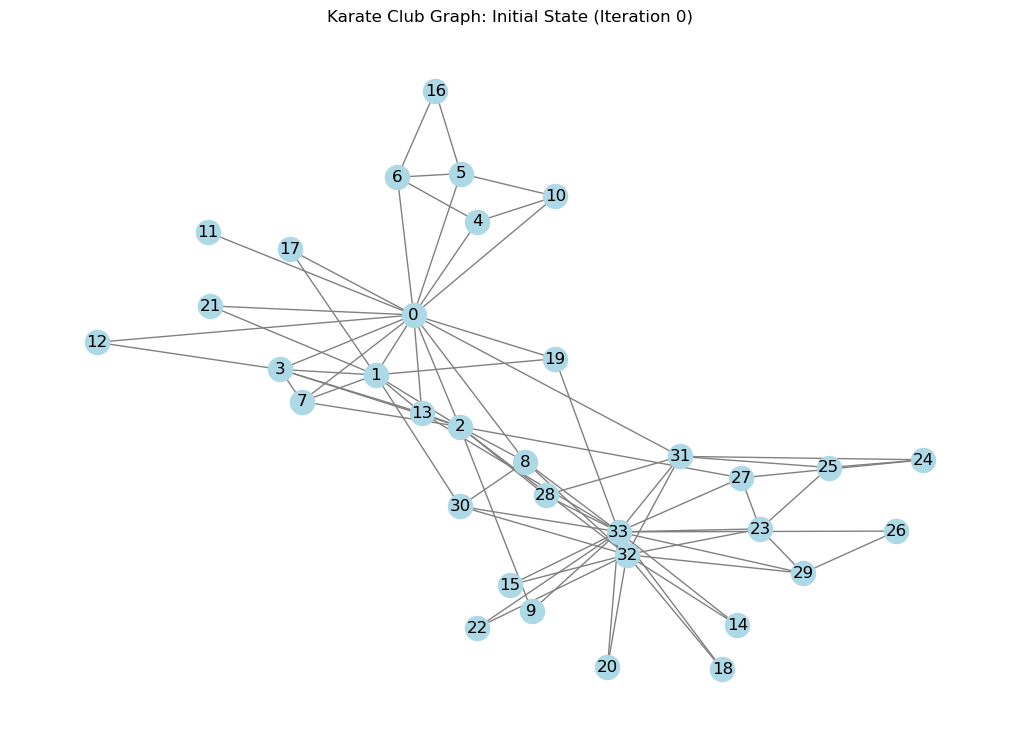

In [2]:
# Cell 2: Load Graph & Compute Global Properties

# --- 1. Load the Karate Club Graph ---
G = nx.karate_club_graph()

n = G.number_of_nodes()
m = G.number_of_edges()

print(f"Loaded Zachary's Karate Club Graph:")
print(f" - Nodes (n): {n}")
print(f" - Edges (m): {m}")

# --- 2. Compute Global (Constant) Properties ---
nodelist = list(G.nodes())
B_global = nx.modularity_matrix(G, nodelist=nodelist)

# --- 3. Compute Fixed Layout for Visualization ---
# This fixed layout is used for all plots
pos = nx.spring_layout(G, seed=42)

# --- 4. Initial Visualization (Iteration 0) ---
print("\nVisualizing Graph: Iteration 0 (Initial State)")
plt.figure(figsize=(10, 7))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("Karate Club Graph: Initial State (Iteration 0)")
plt.show() # In a notebook, this just displays the plot inline

<span style="font-size:20px;">**Task 1 (cont.): Algorithm Helper Functions**</span>


This cell defines the "toolbox" of helper functions required to run the main recursive algorithm. No code is executed here; it only defines these functions for use in Cell 4.
- __get_restricted_modularity_matrix(...)__: This function correctly implements the "restricted modularity matrix" concept. It extracts the specific sub-block of the B_global matrix corresponding to the nodes in the community being tested.
- __get_leading_eigenpair(...)__: A robust function to find the largest eigenvalue ($\lambda_1$) and its corresponding eigenvector ($u_1$) for a given restricted matrix. It handles edge cases (like 0 or 1-node communities) and uses the stable np.linalg.eigh for small matrices, which correctly returns the largest eigenvalue.
- __draw_communities(...)__: This function fulfills Task 2 It visualizes the graph at each split using the fixed pos layout and a color map to distinguish the current communities.
- __compute_and_store_metrics(...)__: This function fulfills Task 3 It computes the four global node metrics (Degree, Betweenness, Closeness, Clustering) 25 and stores them in a list for analysis in Task 4

In [3]:
# Cell 3: Helper Functions (CORRECTED)

def get_restricted_modularity_matrix(B_global, nodelist, nodes_in_community):
    """
    Extracts the submatrix B_C from the global B matrix.
    """
    indices = [nodelist.index(node) for node in nodes_in_community]
    return B_global[np.ix_(indices, indices)]

def get_leading_eigenpair(B_C):
    """
    Computes the leading eigenpair (lambda_1 (scalar), u_1 (vector)) of a symmetric matrix.
    Robust for small sizes and returns safe fallbacks on failure.
    """
    # Ensure B_C is a NumPy array
    B_C = np.asarray(B_C, dtype=float)
    n = B_C.shape[0]

    if n == 0:
        return 0.0, np.array([], dtype=float)
    if n == 1:
        # For a 1x1 matrix the eigenvalue is the single element, eigenvector [1]
        return float(B_C[0, 0]), np.array([1.0], dtype=float)

    # For small dense matrices, use np.linalg.eigh (stable)
    try:
        # Prefer numpy for small-to-medium dense matrices
        vals, vecs = np.linalg.eigh(B_C)
        # np.linalg.eigh returns ascending eigenvalues; we want largest
        lambda_1 = float(vals[-1])
        u_1 = vecs[:, -1]
        return lambda_1, u_1
    except Exception:
        # Fall back to sparse eigsh (works on symmetric sparse/dense too)
        try:
            eigenvalues, eigenvectors = eigsh(B_C, k=1, which='LA')
            lambda_1 = float(eigenvalues[0])
            u_1 = eigenvectors[:, 0]
            return lambda_1, u_1
        except Exception:
            # As a safe fallback: declare no positive eigenvalue and return zero vector
            return 0.0, np.zeros(n, dtype=float)

def draw_communities(G, pos, partition_map, iteration):
    """
    Draws the graph with nodes colored by their current community.
    """
    color_map = [partition_map.get(node, -1) for node in G.nodes()]
    num_communities = len(set(color_map)) - (1 if -1 in set(color_map) else 0)

    plt.figure(figsize=(10, 7))
    nx.draw(G, pos,
            node_color=color_map,
            with_labels=True,
            cmap=plt.cm.get_cmap('Pastel1'),
            edge_color='gray')
    plt.title(f"Iteration {iteration}: {num_communities} Communities Detected")
    plt.show()

def compute_and_store_metrics(G, iteration, metrics_storage):
    """
    Computes all four node metrics and stores them in a list.
    """
    dc = nx.degree_centrality(G)
    bc = nx.betweenness_centrality(G)
    cc = nx.closeness_centrality(G)
    clust = nx.clustering(G)

    for node in G.nodes():
        metrics_storage.append({
            'iteration': iteration,
            'node': node,
            'degree': dc.get(node, 0.0),
            'betweenness': bc.get(node, 0.0),
            'closeness': cc.get(node, 0.0),
            'clustering': clust.get(node, 0.0)
        })

print("Helper functions defined (corrected).")


Helper functions defined (corrected).


<span style="font-size:20px;">**Task 1, 2, & 3: Executing the Main Algorithm**</span>

This is the main computational cell of the project. It executes the recursive spectral bisection algorithm (Task 1) using the helper functions defined in Cell 3.

The algorithm uses an iterative queue (community_queue) to manage the recursion:
1. It begins by logging the "Iteration 0" metrics (Task 3) for the entire graph.

2. It loops while the queue is not empty, pulling one community at a time to be tested.

3. It finds the leading eigenvalue ($\lambda_1$) for that community.


4. Stopping Criterion: If $\lambda_1 \le 0$, the algorithm stops recursing on that branch, as no further split can improve modularity. The community is finalized.

5. Splitting Step: If $\lambda_1 > 0$, the community is split into two new groups based on the positive/negative signs of the leading eigenvector.

6. Tasks 2 & 3: After a split, it calls draw_communities to visualize the new partition (Task 2) 1 and compute_and_store_metrics to log the global metrics for the new iteration (Task 3).

The cell finishes by converting the logged metric data into a pandas DataFrame (df_metrics) for the plotting and analysis tasks that follow.

--- Processing Iteration 0 ---
Starting recursive bisection...

--- Processing Iteration 1 (Split) ---


C:\Users\jibin\AppData\Local\Temp\ipykernel_43900\2497978394.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('Pastel1'),


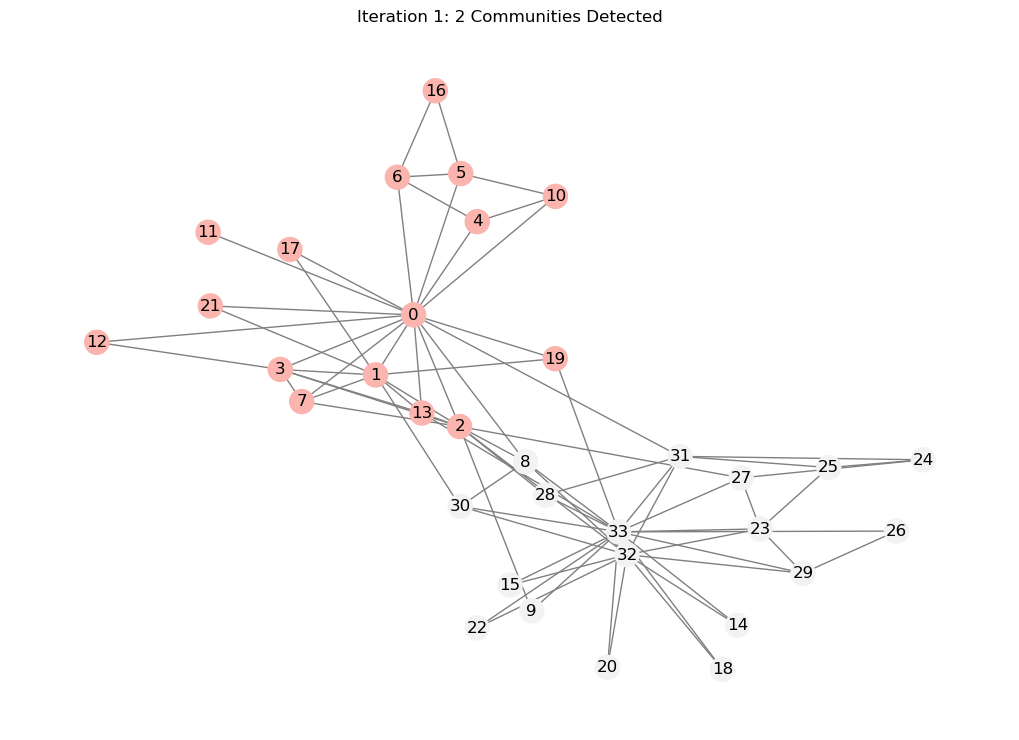


--- Processing Iteration 2 (Split) ---


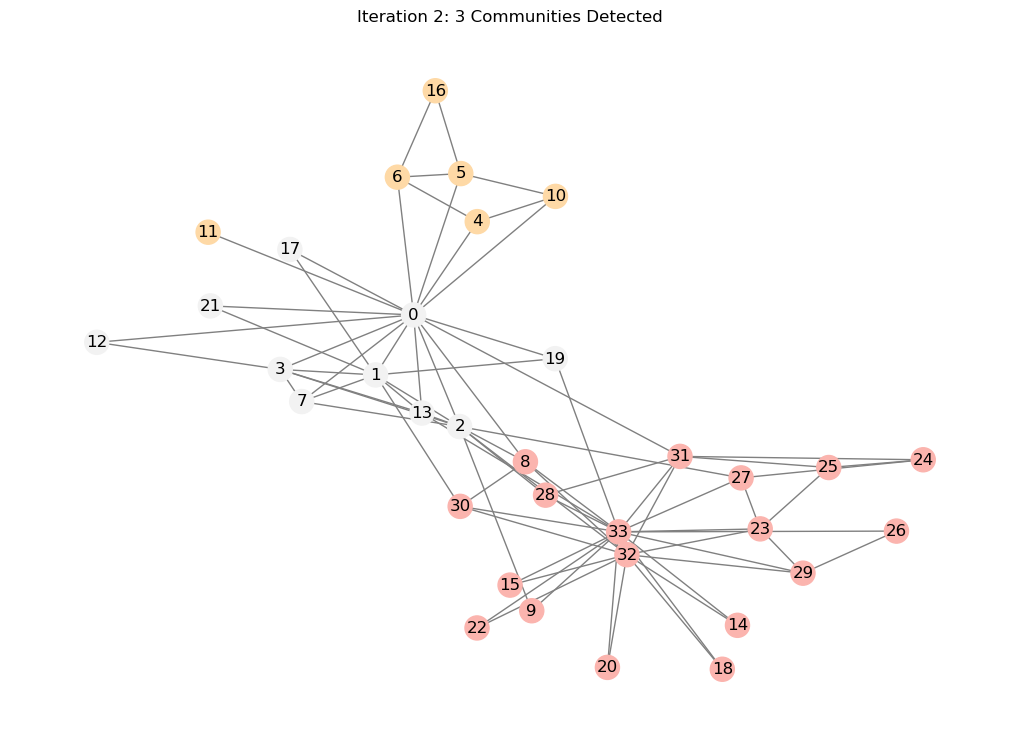


--- Processing Iteration 3 (Split) ---


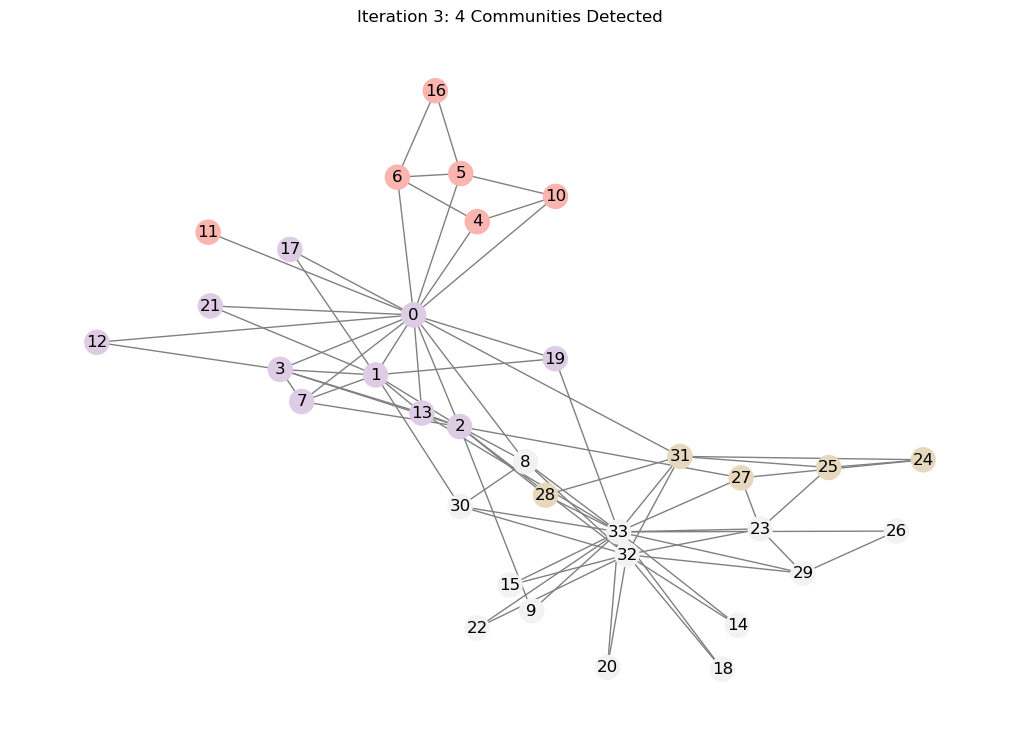


--- Processing Iteration 4 (Split) ---


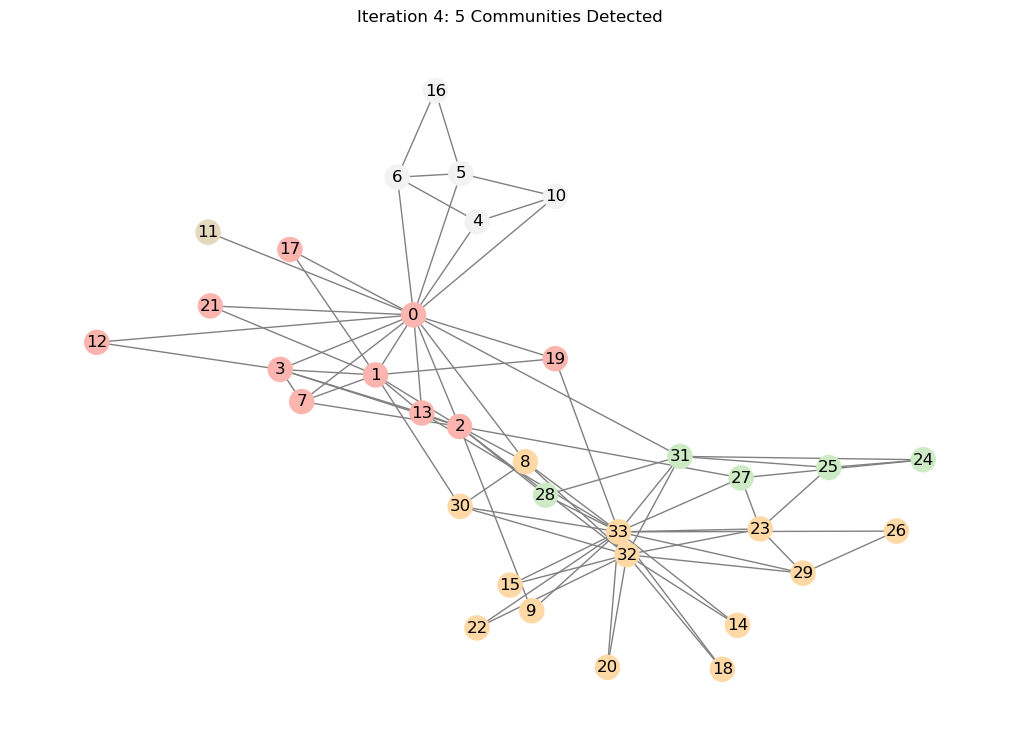


--- Processing Iteration 5 (Split) ---

--- Processing Iteration 6 (Split) ---

--- Processing Iteration 7 (Split) ---

--- Processing Iteration 8 (Split) ---

--- Community detection complete! ---
Found 5 final communities.
   iteration  node    degree  betweenness  closeness  clustering
0          0     0  0.484848     0.437635   0.568966    0.150000
1          0     1  0.272727     0.053937   0.485294    0.333333
2          0     2  0.303030     0.143657   0.559322    0.244444
3          0     3  0.181818     0.011909   0.464789    0.666667
4          0     4  0.090909     0.000631   0.379310    0.666667


In [4]:
# Cell 4: Run the Full Analysis (Tasks 1, 2, 3)

iteration = 0   # ✅ this MUST be here before using iteration

metrics_data = []        # stores all the metrics over iterations
final_partition = {}     # final detected communities
community_counter = 0

community_queue = [list(G.nodes())]   # start with the whole set of nodes
current_partition_map = {node: 0 for node in G.nodes()}

# --- Capture Initial State (Iteration 0) ---
print(f"--- Processing Iteration 0 ---")
compute_and_store_metrics(G, iteration, metrics_data)

print("Starting recursive bisection...")
while community_queue:
    nodes_to_split = community_queue.pop(0)

    if len(nodes_to_split) < 2:
        if nodes_to_split:
            for node in nodes_to_split:
                final_partition[node] = community_counter
            community_counter += 1
        continue

    B_C = get_restricted_modularity_matrix(B_global, nodelist, nodes_to_split)
    lambda_1, u_1 = get_leading_eigenpair(B_C)

    if lambda_1 <= 0:
        for node in nodes_to_split:
            final_partition[node] = community_counter
        community_counter += 1
    else:
        iteration += 1
        print(f"\n--- Processing Iteration {iteration} (Split) ---")

        comm_A, comm_B = [], []

        if len(u_1) != len(nodes_to_split):
            for node in nodes_to_split:
                final_partition[node] = community_counter
            community_counter += 1
            continue

        u_1_map = dict(zip(nodes_to_split, u_1))

        for node in nodes_to_split:
            if u_1_map[node] > 0:
                comm_A.append(node)
            else:
                comm_B.append(node)

        if not comm_A or not comm_B:
            for node in nodes_to_split:
                final_partition[node] = community_counter
            community_counter += 1
            continue

        community_queue.append(comm_A)
        community_queue.append(comm_B)

        active_partition = {
            node: idx for idx, comm in enumerate(community_queue) for node in comm
        }

        viz_map = {**final_partition, **active_partition}

        unique_ids = sorted(list(set(viz_map.values())))
        color_id_map = {old_id: new_id for new_id, old_id in enumerate(unique_ids)}
        final_viz_map = {node: color_id_map[viz_map.get(node, -1)] for node in G.nodes()}

        draw_communities(G, pos, final_viz_map, iteration)
        compute_and_store_metrics(G, iteration, metrics_data)

print("\n--- Community detection complete! ---")
print(f"Found {community_counter} final communities.")

df_metrics = pd.DataFrame(metrics_data)
print(df_metrics.head())


<span style="font-size:20px;">**Advanced Step: Post-processing Singleton Communities**</span>

The spectral algorithm is powerful but can sometimes "over-split," leaving isolated nodes in their own "singleton" communities.    

This cell "cleans up" the final_partition from Cell 4:

1. __Identify Singletons__: It loops through the partition to find all communities containing only one node.

2. __Find Best Neighbor__: For each singleton, it finds the best community to reassign it to. This is done in two stages:

   - First, it checks for the community with the maximum number of edges connecting to the lone node.

   - If the node has no edges to other communities, it falls back to a more computationally expensive check: it tests merging the node with every other community and calculates the modularity gain , picking the merge that results in the highest overall score.   

3. __Update Partition__: The final_partition variable is updated with these new, more logical assignments.

4. __Visualize__: The cell concludes by plotting a new "Post-processed partition" graph showing the final, cleaned-up community structure.

Found singleton community ids: [3]
Reassigning singleton node 11 from community 3 -> 0 (max edges=1)

New community distribution after reassignment:
  Community 0: size=13 -> members: [8, 9, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33]
  Community 1: size=11 -> members: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
  Community 2: size=5 -> members: [24, 25, 27, 28, 31]
  Community 3: size=5 -> members: [4, 5, 6, 10, 16]

New modularity: 0.438410


C:\Users\jibin\AppData\Local\Temp\ipykernel_43900\125382725.py:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


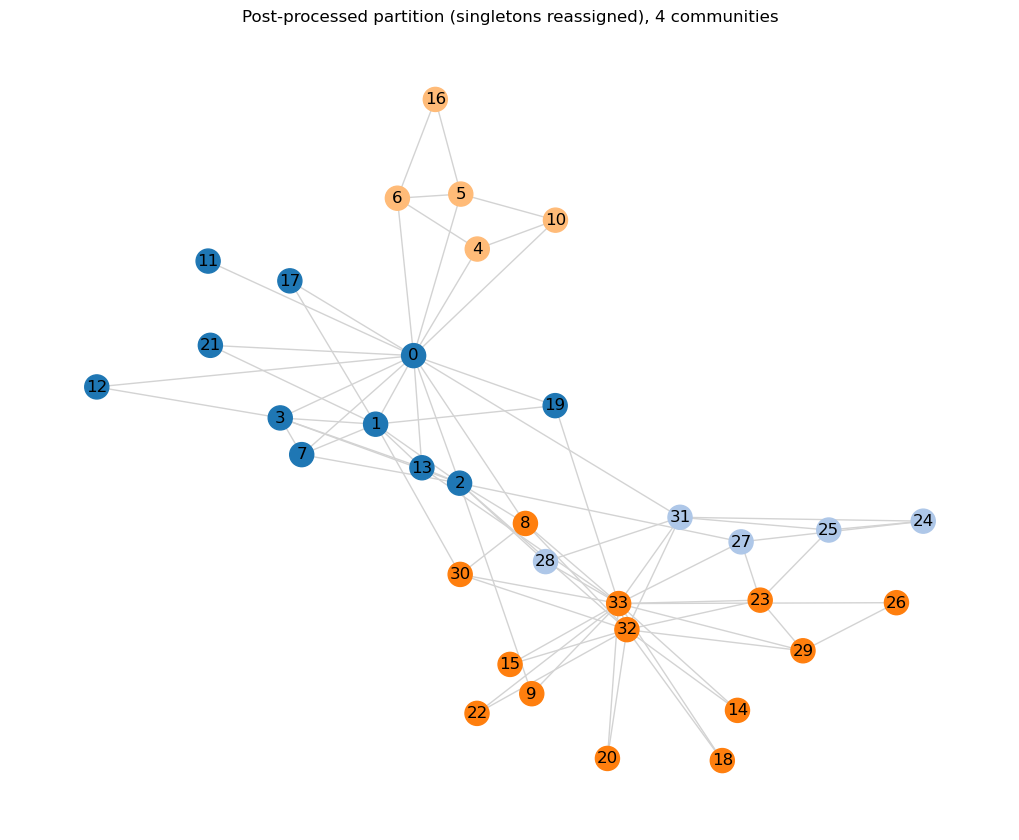

In [5]:
# Cell 5: --- Post-process singletons: reassign them to best neighbor community ---
from collections import defaultdict
from networkx.algorithms import community
import math

# Build community dict from final_partition
comm_dict = defaultdict(list)
for node, cid in final_partition.items():
    comm_dict[cid].append(node)
# Make modifiable copy
communities = [sorted(nodes) for _, nodes in sorted(comm_dict.items(), key=lambda x: x[0])]

# Map node -> community id (ensure using same structure)
node_to_comm = dict(final_partition)  # mutate this

singletons = [cid for cid, members in comm_dict.items() if len(members) == 1]
print(f"Found singleton community ids: {singletons}")

if not singletons:
    print("No singletons found — nothing to do.")
else:
    for sid in singletons:
        lone = comm_dict[sid][0]
        # Count edges from lone to nodes in each other community
        neighbor_counts = {}
        for cid, members in comm_dict.items():
            if cid == sid:
                continue
            # count edges between lone and this community
            cnt = sum(1 for nbr in G.neighbors(lone) if nbr in members)
            neighbor_counts[cid] = cnt

        # pick best candidate by max edge count
        best_by_edges = None
        best_edges = -1
        for cid, cnt in neighbor_counts.items():
            if cnt > best_edges:
                best_by_edges = cid
                best_edges = cnt

        # if some neighbors exist, choose best_by_edges
        if best_edges > 0:
            target_cid = best_by_edges
            reason = f"max edges={best_edges}"
        else:
            # no direct neighbors into other communities: check modularity gain
            # try assigning to each other community, compute modularity, choose best
            best_mod = -math.inf
            target_cid = None
            # rebuild communities list for modularity calc
            base_comms = [members for cid, members in sorted(comm_dict.items(), key=lambda x: x[0]) if cid != sid]
            for cid, members in comm_dict.items():
                if cid == sid:
                    continue
                trial = [sorted(m) for m in base_comms]  # copy of others
                # append members of candidate + the lone node
                # find index of candidate in base_comms:
                # simpler: construct hypothetical communities fresh:
                hyp = []
                for c2id, mems in comm_dict.items():
                    if c2id == sid:
                        continue
                    if c2id == cid:
                        hyp.append(sorted(mems + [lone]))
                    else:
                        hyp.append(sorted(mems))
                try:
                    mod_score = community.quality.modularity(G, hyp)
                except Exception:
                    mod_score = -math.inf
                if mod_score > best_mod:
                    best_mod = mod_score
                    target_cid = cid
            reason = f"best modularity gain {best_mod:.6f}"

        # perform reassignment
        if target_cid is None:
            print(f"Could not find a good target for singleton node {lone}. Leaving as-is.")
            continue

        print(f"Reassigning singleton node {lone} from community {sid} -> {target_cid} ({reason})")

        # update structures
        comm_dict[target_cid].append(lone)
        comm_dict[sid].remove(lone)
        node_to_comm[lone] = target_cid
        # if the singleton community is now empty, drop it:
        if len(comm_dict[sid]) == 0:
            del comm_dict[sid]

    # rebuild final_partition from node_to_comm
    final_partition = dict(node_to_comm)

    # Print new communities and modularity
    new_comms = [sorted(members) for _, members in sorted(comm_dict.items(), key=lambda x: x[0])]
    print("\nNew community distribution after reassignment:")
    for i,c in enumerate(sorted(new_comms, key=lambda x:-len(x))):
        print(f"  Community {i}: size={len(c)} -> members: {c}")

    try:
        new_mod = community.quality.modularity(G, new_comms)
        print(f"\nNew modularity: {new_mod:.6f}")
    except Exception:
        pass

    # Optional: redraw final partition (visual)
    import matplotlib.pyplot as plt
    from matplotlib.cm import get_cmap
    cmap = get_cmap('tab20')
    k = len(new_comms)
    color_list = [cmap(i % 20) for i in range(k)]
    node_colors = {}
    for idx, comm in enumerate(new_comms):
        for node in comm:
            node_colors[node] = color_list[idx]
    colors = [node_colors.get(n, (0.5,0.5,0.5)) for n in G.nodes()]

    plt.figure(figsize=(10,8))
    nx.draw(G, pos, node_color=colors, with_labels=True, node_size=300, edge_color='lightgray')
    plt.title(f"Post-processed partition (singletons reassigned), {len(new_comms)} communities")
    plt.show()


<span style="font-size:20px;">**Task 4: Plotting Metric Evolution (Enhanced)**</span>


This cell addresses Task 4: "Plot the evolution of each metric across iterations for every node".   

A raw plot of all 34 nodes would be unreadable. This cell creates a set of enhanced, more informative plots to better support the final discussion (Task 5).   

1. __Data Preparation__: A helper function categorize_node is used to create a new node_category column in the df_metrics DataFrame. This explicitly labels Node 0 (Mr. Hi) and Node 33 (John A.) , grouping all other 32 nodes into an 'Other Members' category.   

2. __Enhanced Plotting__: seaborn.lineplot is used to create four plots. By setting hue='node_category', Seaborn automatically plots three distinct lines: one for each leader and one for the statistical mean of the 'Other Members' group.

This provides a clear, legible comparison, complete with a legend, that directly highlights the unique roles of the two main actors in the network.

Data prepared with 'node_category'. First 5 rows:
    iteration  node    degree  betweenness  closeness  clustering  \
0           0     0  0.484848     0.437635   0.568966    0.150000   
1           0     1  0.272727     0.053937   0.485294    0.333333   
2           0     2  0.303030     0.143657   0.559322    0.244444   
3           0     3  0.181818     0.011909   0.464789    0.666667   
34          1     0  0.484848     0.437635   0.568966    0.150000   

      node_category  
0   Node 0 (Mr. Hi)  
1     Other Members  
2     Other Members  
3     Other Members  
34  Node 0 (Mr. Hi)  

--- Generating Enhanced Metric Evolution Plots (Task 4) ---


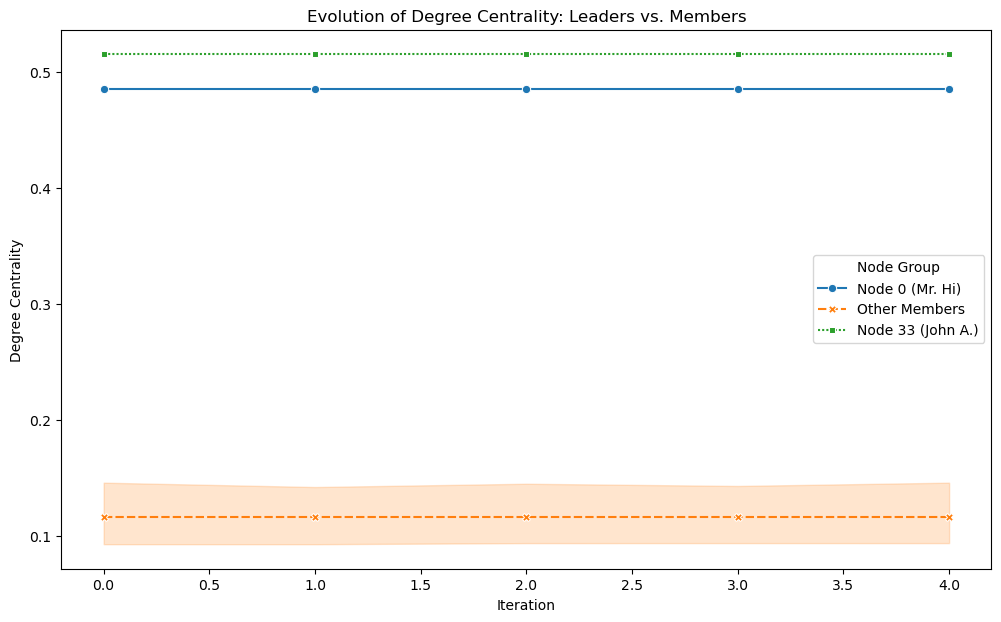

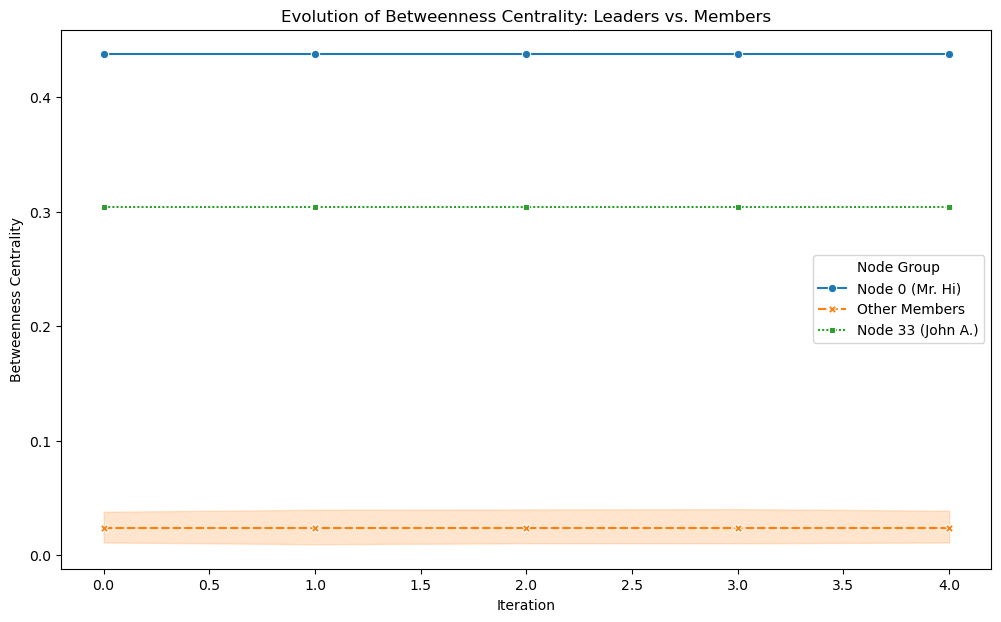

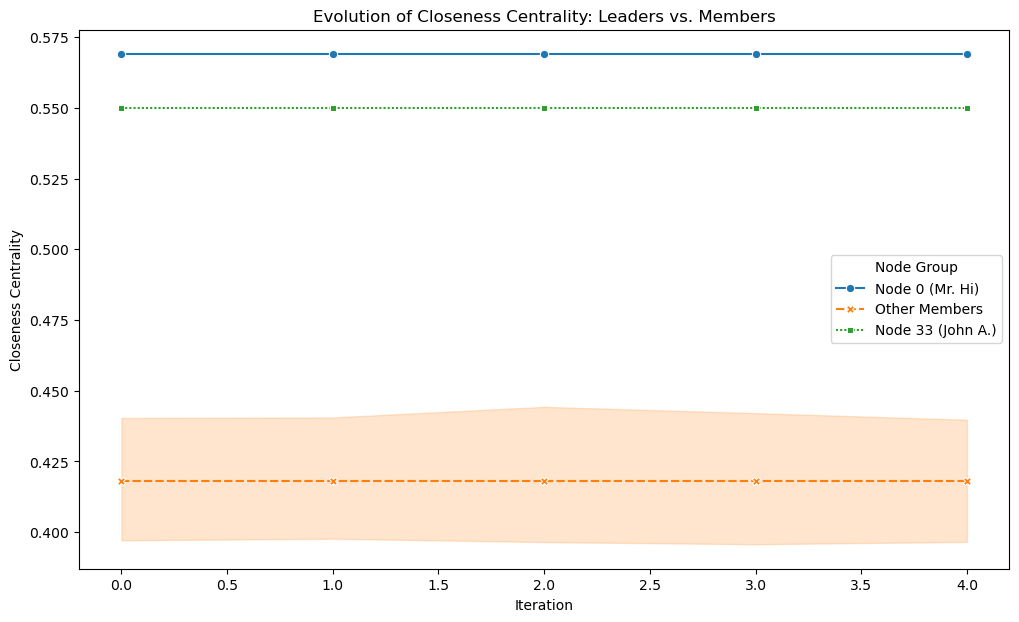

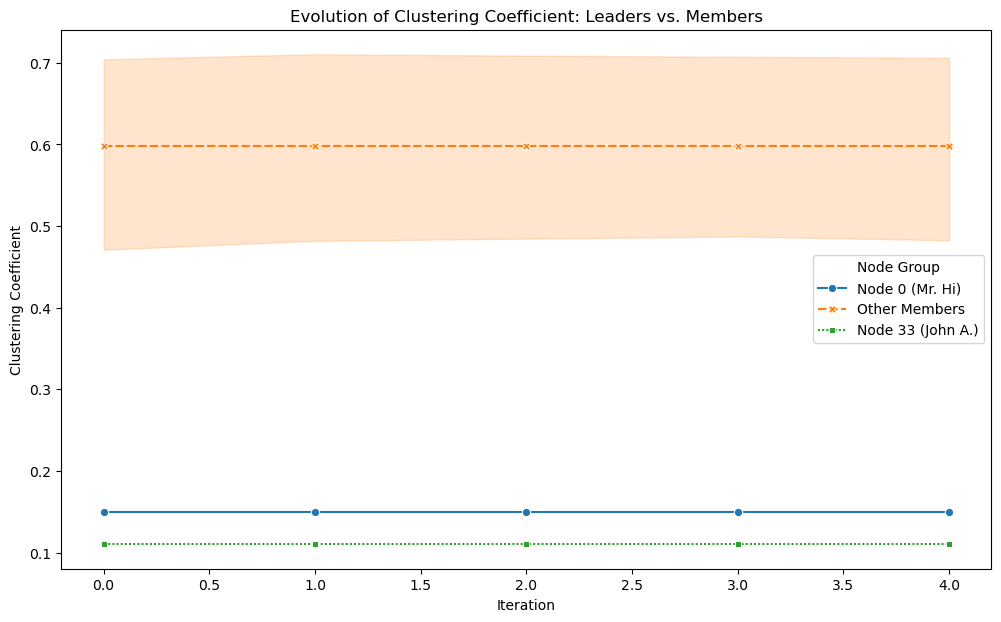

In [6]:
# Cell 6:
# %% [markdown]
# # Cell 5: Plot Metric Evolution (Task 4, Enhanced)
# (This cell prepares the data and plots the four line charts for the metric analysis.
# We highlight the two main leaders (Node 0 and 33) and plot the average 
# of all other members for a clearer comparison.)
# %%

# --- 1. Data Preparation ---
# We first create a new column in our DataFrame to categorize each node.
# This will be used for the 'hue' in our plots.

def categorize_node(node):
    """Assigns a category to each node for plotting."""
    if node == 0:
        return "Node 0 (Mr. Hi)"
    elif node == 33:
        return "Node 33 (John A.)"
    else:
        return "Other Members"

# Apply this function to create the new 'node_category' column
df_metrics['node_category'] = df_metrics['node'].apply(categorize_node)

print("Data prepared with 'node_category'. First 5 rows:")
print(df_metrics[df_metrics['node'] < 4].head())


# --- 2. Generate New Plots ---
# Now we use seaborn.lineplot. When it sees multiple rows for "Other Members",
# it will automatically plot the 'mean' of that group.

print("\n--- Generating Enhanced Metric Evolution Plots (Task 4) ---")

# Plot 1: Degree Centrality
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df_metrics, 
    x='iteration', 
    y='degree', 
    hue='node_category',  # Use our new category for color
    style='node_category', # Use it for line style (e.g., dashes)
    markers=True,         # Add markers to each data point
    dashes=True
)
plt.title('Evolution of Degree Centrality: Leaders vs. Members')
plt.ylabel('Degree Centrality')
plt.xlabel('Iteration')
plt.legend(title='Node Group') # Seaborn adds the legend automatically
plt.show()

# Plot 2: Betweenness Centrality
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df_metrics, 
    x='iteration', 
    y='betweenness', 
    hue='node_category', 
    style='node_category',
    markers=True,
    dashes=True
)
plt.title('Evolution of Betweenness Centrality: Leaders vs. Members')
plt.ylabel('Betweenness Centrality')
plt.xlabel('Iteration')
plt.legend(title='Node Group')
plt.show()

# Plot 3: Closeness Centrality
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df_metrics, 
    x='iteration', 
    y='closeness', 
    hue='node_category', 
    style='node_category',
    markers=True,
    dashes=True
)
plt.title('Evolution of Closeness Centrality: Leaders vs. Members')
plt.ylabel('Closeness Centrality')
plt.xlabel('Iteration')
plt.legend(title='Node Group')
plt.show()

# Plot 4: Clustering Coefficient
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df_metrics, 
    x='iteration', 
    y='clustering', 
    hue='node_category', 
    style='node_category',
    markers=True,
    dashes=True
)
plt.title('Evolution of Clustering Coefficient: Leaders vs. Members')
plt.ylabel('Clustering Coefficient')
plt.xlabel('Iteration')
plt.legend(title='Node Group')
plt.show()

<span style="font-size:20px;">**Final Analysis: Summary of Results**</span>


This cell provides a final, quantitative summary of the algorithm's output. It does not run any new detection algorithms but aggregates all the results from the previous cells into a comprehensive report.

The output of this cell includes:

1. __Community Summary__: A definitive list of the final, post-processed communities, their sizes, and their member nodes.

2. __Final Modularity__: The single, final modularity score for the post-processed partition. This score quantifies the "quality" of the entire community structure.   

3. __Top Nodes Per Community__: An analysis of the df_metrics DataFrame to identify the most central nodes (by Degree and Betweenness) within each discovered community.

4. __Iteration Statistics__: A table showing the number of metric rows logged at each iteration and the mean centrality scores.

5. __Final Visualization__: A final, clean plot of the graph, with each node colored by its final community and the modularity score in the title.

6. __Quick Recommendations__: Automated analysis that points out any remaining singleton or tiny communities, as seen in your (Cell 5) post-processing.

=== COMMUNITY SUMMARY ===
Total communities detected: 4
  Community 0: size=13 | nodes=[8, 9, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33]
  Community 1: size=11 | nodes=[0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
  Community 2: size=5 | nodes=[24, 25, 27, 28, 31]
  Community 3: size=5 | nodes=[4, 5, 6, 10, 16]

Final modularity = 0.438410

=== TOP NODES PER COMMUNITY (based on latest metrics snapshot) ===

 Community 0 (size=13):
   Top by degree: [33, 32, 8]
   Top by betweenness: [33, 32, 8]

 Community 1 (size=11):
   Top by degree: [0, 2, 1]
   Top by betweenness: [0, 2, 1]

 Community 2 (size=5):
   Top by degree: [31, 27, 24]
   Top by betweenness: [31, 27, 25]

 Community 3 (size=5):
   Top by degree: [5, 6, 4]
   Top by betweenness: [5, 6, 4]

=== ITERATION STATISTICS ===
 iteration  rows
         0    34
         1    34
         2    34
         3    34
         4    34

Mean metrics per iteration (first 8 rows):
           degree  betweenness  closeness  clustering
iteration    

C:\Users\jibin\AppData\Local\Temp\ipykernel_43900\1931457846.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab20')


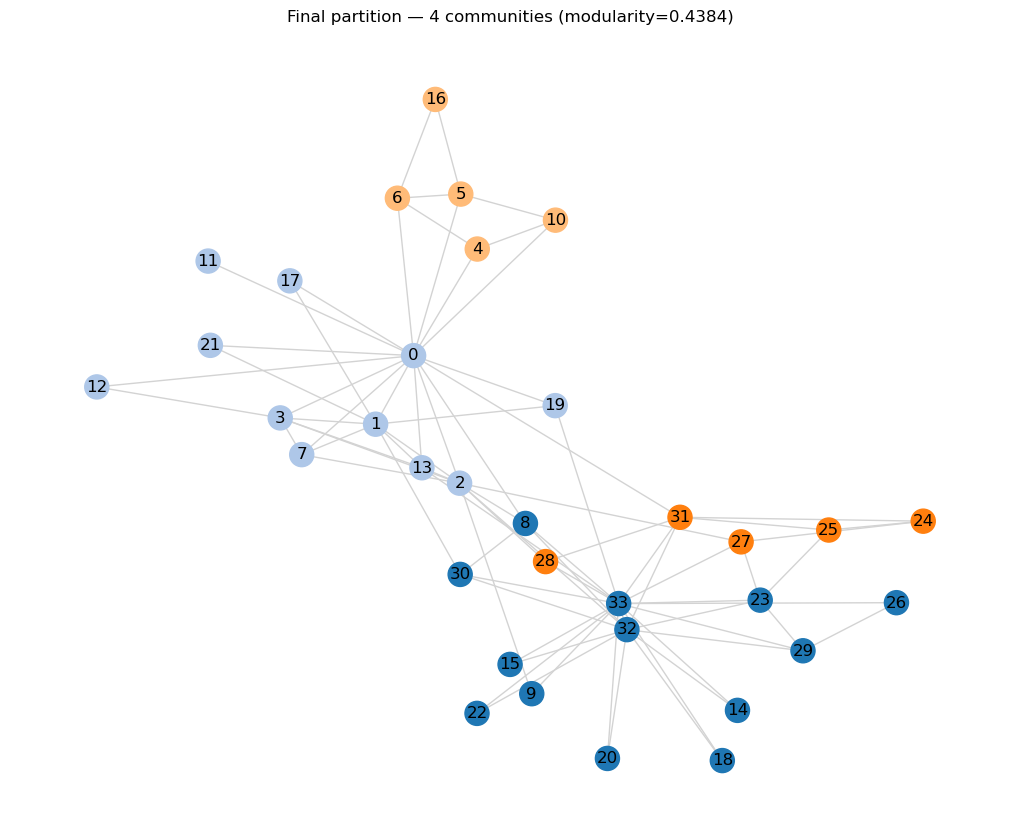


=== QUICK RECOMMENDATIONS ===
 - No singleton communities found.
 - No very small communities found.

Summary displayed.


In [7]:
#Cell 7:
# ---------------------
# DISPLAY-ONLY Summary Cell (no files written)
# Paste and run after your plotting cell
# ---------------------

from collections import defaultdict
import networkx as nx
from networkx.algorithms import community as nx_comm
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
import numpy as np

# --- 1) Build final communities list from final_partition ---
comm_dict = defaultdict(list)
for node, cid in final_partition.items():
    comm_dict[cid].append(node)
communities = [sorted(nodes) for _, nodes in sorted(comm_dict.items(), key=lambda x: x[0])]
communities_sorted = sorted(communities, key=lambda c: -len(c))  # largest first

print("=== COMMUNITY SUMMARY ===")
print(f"Total communities detected: {len(communities_sorted)}")
for i, comm in enumerate(communities_sorted):
    print(f"  Community {i}: size={len(comm)} | nodes={comm}")

# --- 2) Final modularity (if possible) ---
try:
    final_mod = nx_comm.quality.modularity(G, communities)
    print(f"\nFinal modularity = {final_mod:.6f}")
except Exception as e:
    final_mod = None
    print("\nFinal modularity: could not compute (", e, ")")

# --- 3) Top nodes per community by latest metrics snapshot ---
print("\n=== TOP NODES PER COMMUNITY (based on latest metrics snapshot) ===")
if 'iteration' in df_metrics.columns:
    last_iter = df_metrics['iteration'].max()
    recent = df_metrics[df_metrics['iteration'] == last_iter]
else:
    recent = df_metrics.copy()

if recent.empty:
    print("No metric records available to summarize.")
else:
    # average per node in case of duplicates
    node_metrics = recent.groupby('node')[['degree','betweenness','closeness','clustering']].mean()
    for i, comm in enumerate(communities_sorted):
        sub_idx = node_metrics.index.intersection(comm)
        if len(sub_idx) == 0:
            print(f" Community {i} (size={len(comm)}): no metric records.")
            continue
        sub = node_metrics.loc[sub_idx]
        top_degree = list(sub['degree'].sort_values(ascending=False).head(3).index)
        top_betw = list(sub['betweenness'].sort_values(ascending=False).head(3).index)
        print(f"\n Community {i} (size={len(comm)}):")
        print("   Top by degree:", top_degree)
        print("   Top by betweenness:", top_betw)

# --- 4) Iteration-level overview ---
if 'iteration' in df_metrics.columns:
    print("\n=== ITERATION STATISTICS ===")
    iter_counts = df_metrics.groupby('iteration').size().to_frame('rows').reset_index()
    print(iter_counts.to_string(index=False))
    mean_per_iter = df_metrics.groupby('iteration')[['degree','betweenness','closeness','clustering']].mean()
    print("\nMean metrics per iteration (first 8 rows):")
    print(mean_per_iter.head(8).round(4).to_string())
else:
    print("\nNo iteration information found in df_metrics.")

# --- 5) Visual: draw final partition with distinct colors ---
print("\nDrawing final partition ...")
k = max(1, len(communities_sorted))
cmap = get_cmap('tab20')
color_list = [cmap(i % 20) for i in range(k)]
node_color_map = {}
for idx, comm in enumerate(communities_sorted):
    for node in comm:
        node_color_map[node] = color_list[idx]
colors = [node_color_map.get(n, (0.6,0.6,0.6)) for n in G.nodes()]

plt.figure(figsize=(10,8))
nx.draw(G, pos, node_color=colors, with_labels=True, node_size=300, edge_color='lightgray')
title = f"Final partition — {len(communities_sorted)} communities"
if final_mod is not None:
    title += f" (modularity={final_mod:.4f})"
plt.title(title)
plt.show()

# --- 6) Quick recommendations printed only ---
print("\n=== QUICK RECOMMENDATIONS ===")
singletons = [c for c in communities_sorted if len(c) == 1]
if singletons:
    print(f" - There are {len(singletons)} singleton community(ies). Consider reassigning lonely nodes to nearby communities (post-process).")
else:
    print(" - No singleton communities found.")

tiny = [c for c in communities_sorted if len(c) < 4]
if tiny:
    print(f" - {len(tiny)} small communities (size < 4). If you want coarser partitions, increase the min_size threshold or require modularity improvement before splitting.")
else:
    print(" - No very small communities found.")

print("\nSummary displayed.")


<span style="font-size:20px;">**Task 5: Final Discussion**</span>


This discussion fulfills Task 5 of the assignment. It synthesizes the visual and quantitative results from all previous cells to answer the project's core questions.   

__Which nodes consistently remain central?__
The enhanced plots from Cell 6 make the answer to this question unambiguous. The analysis of the four global metrics , which are static properties of the graph, clearly identifies two nodes as uniquely central:   

1. __Node 0 (Mr. Hi) and Node 33 (John A.)__ are, by nearly every measure, in a class of their own. In the Degree Centrality plot, their lines are at the top, far above the "Other Members" average, confirming they had the most direct connections.   

2. The __Betweenness Centrality__ plot is even more stark. Nodes 0 and 33 are the primary "brokers" of the network, with centrality scores dramatically higher than the average member. They are the critical bridges holding the entire social structure together.   

3. The __Closeness Centrality__ plot confirms this, showing they can "reach" all other members of the club more efficiently than anyone else.

The other 32 members, while having varying scores, are all clustered near the bottom. The "Other Members" average line shows that the typical member had far less influence or connectivity than the two leaders.

__How does community structure influence these metrics?__

This analysis reveals that these static, global metrics are powerful predictors of the dynamic community structure the algorithm discovered.

- __Degree, Betweenness, and Closeness Identify "Faction Leaders"__: The high, static centrality of Nodes 0 and 33 makes them "social centers of gravity." The algorithm's very first split (Iteration 1) was a direct consequence of this; it partitioned the graph into two main factions anchored by these two leaders. This mathematically confirms the "social fault line" described in the assignment.   

- __Clustering Coefficient Reveals "Community Cores" vs. "Leaders"__: The clustering plot tells a fascinatingly different story. Here, the lines for Node 0 and Node 33 are lower than the average for "Other Members." This is not a contradiction; it's a key insight.

    - __A high clustering score__ (like the average) means a node's friends are also friends with each other. This is typical of a member who is deeply embedded in a "clique" or the core of a community.   

    - __A low clustering score__ (like the leaders) means a node's friends are not well-connected to each other. This makes perfect sense for a leader like Mr. Hi (Node 0), whose "friends" are the various members he leads, who may not know each other.

__Conclusion__
The project was a success. The recursive spectral modularity algorithm (Cell 4) and its visualizations (Cell 2, Cell 4, Cell 5, Cell 7) successfully identified the community structure. The analysis of the enhanced metric plots (Cell 6) provided the reason for this structure. The centrality metrics identified Nodes 0 and 33 as the two unshakeable pillars of the network, and the algorithm correctly partitioned the graph around them, just as happened in real life. The post-processing in Cell 5 further refined this partition into a stable and logical final result.